# Generate Synthetic Data for Tests

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datadrivenquadrature as ddq

In [2]:
def generate_spectra(x_idx, y_idx, s=1000):
    spectra = []
    x = np.arange(0, 12, 1./s)
    for val in x:
        if val < 8:
            spectra.append((-x_idx / 16.) * (val) * (val - 8))
        else:
            spectra.append((-y_idx / 4.) * (val - 8) * (val - 12))
    return spectra

def compute_exact_integral(x_idx, y_idx):
    return 16./3 * x_idx + 8./3 * y_idx

In [3]:
n = 10 # size of square block of data
s = 1000 # number of points on the integration axis
x_integrated = []
x_spectra = []

for y_idx in range(n):
    x_integrated_row = []
    x_spectra_row = []
    for x_idx in range(n):
        x_integrated_row.append(compute_exact_integral(x_idx + 1, y_idx + 1))
        x_spectra_row.append(generate_spectra(x_idx + 1, y_idx + 1, s))
    x_integrated.append(x_integrated_row)
    x_spectra.append(x_spectra_row)

x_range = np.arange(0, 12, 1./s)

x = xr.DataArray(x_spectra,
    dims=("x_idx", "y_idx", "integration_axis"), 
    coords={"x_idx": list(np.arange(1, n + 1, 1)),
             "y_idx": list(np.arange(1, n + 1, 1)),
             "integration_axis": x_range}
)
y = xr.DataArray(x_integrated,
    dims=("x_idx", "y_idx"), 
    coords={"x_idx": list(np.arange(1, n + 1, 1)),
             "y_idx": list(np.arange(1, n + 1, 1))}
)

[0.         0.00049994 0.00099975 ... 0.00299775 0.001999   0.00099975]


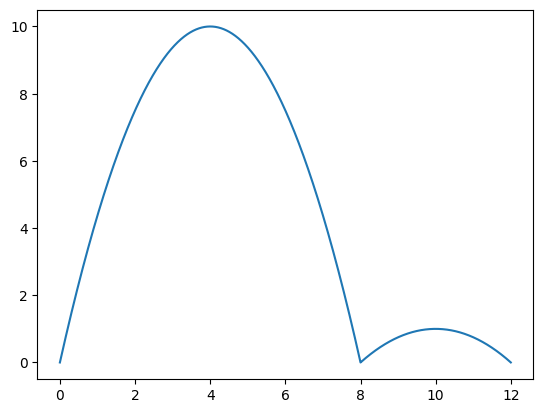

In [4]:
print(x[0][0].values)
plt.plot(x_range, x[0][9].values)

In [5]:
y_ref = y.values.flatten()
print(y_ref.shape)

(100,)


In [7]:
def user_cost_fnc(y, y_hat):
    cost = sum(y - y_hat)
    return cost

def map_func(x, point_set, x_sup=None):
    point_idxs = [point[0] for point in point_set]
    points = np.array(x[:,:,point_idxs].values).reshape((n*n, 2))
    return points

params = {}
integration_list = ['integration_axis']
params['integration_list'] = integration_list
params['n_points'] = 2
params['epochs'] = 100
params['success'] = 25
params['block_size'] = 100

history = ddq.optimize(x, y_ref, user_cost_fnc, map_func, params, x_sup=None)

1 0 [[3915], [10265]]
1 1 [[9274], [10265]]
1 2 [[9274], [4740]]
1 3 [[1916], [4740]]
1 4 [[581], [4740]]
1 5 [[581], [7390]]
1 6 [[6180], [7390]]
1 7 [[3537], [7390]]
1 8 [[7243], [7390]]
1 9 [[7243], [4362]]
1 10 [[7243], [4012]]
1 11 [[7243], [6407]]
1 12 [[1432], [6407]]
1 13 [[1432], [9604]]
1 14 [[1432], [4500]]
1 15 [[4432], [4500]]
1 16 [[3391], [4500]]
1 17 [[3391], [7012]]
1 18 [[4447], [7012]]
1 19 [[4447], [7154]]
1 20 [[7467], [7154]]
1 21 [[9520], [7154]]
1 22 [[9520], [3355]]
1 23 [[9520], [9674]]
1 24 [[9520], [6724]]
block finished
25 25 25
appended stuff
epoch finished
2 0 [[8655], [6724]]
2 1 [[8655], [7320]]
2 2 [[8655], [2515]]
2 3 [[5589], [2515]]
2 4 [[9583], [2515]]
2 5 [[7219], [2515]]
2 6 [[7219], [8137]]
2 7 [[7219], [446]]
2 8 [[7219], [8506]]
2 9 [[6382], [8506]]
2 10 [[6382], [6176]]
2 11 [[9987], [6176]]
2 12 [[9987], [5672]]
2 13 [[9987], [1776]]
2 14 [[3415], [1776]]
2 15 [[3415], [9313]]
2 16 [[3415], [5753]]
2 17 [[3415], [11190]]
2 18 [[2952], [11190

dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(7, 12)
6.24960648696649e-10
[[11370], [7918]]
[  5.02409998 131.42844235]


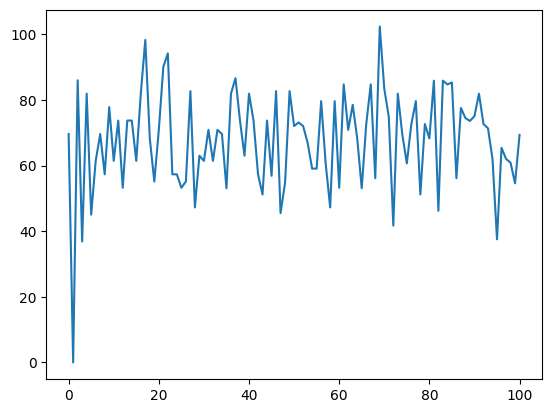

In [16]:
mean_costs = []
for cost in history['cost']:
    mean_costs.append(np.mean(cost))

plt.plot(np.arange(len(mean_costs)), mean_costs)
print(history.keys())
print(history['best'])
print(history['cost'][7][12])
print(history['point_sets'][7][12])
print(history['weight_sets'][7][12])

In [18]:
def user_cost_fnc(y, y_hat):
    cost = sum(y - y_hat)
    return cost

def map_func(x, point_set, x_sup=None):
    point_idxs = [point[0] for point in point_set]
    points = np.array(x[:,:,point_idxs].values).reshape((n*n, 8))
    return points

params = {}
integration_list = ['integration_axis']
params['integration_list'] = integration_list
params['n_points'] = 8
params['epochs'] = 100
params['success'] = 25
params['block_size'] = 100

history = ddq.optimize(x, y_ref, user_cost_fnc, map_func, params, x_sup=None)

1 0 [[10932], [6027], [5917], [4546], [8838], [4052], [9861], [9760]]
1 1 [[10932], [6027], [5917], [4546], [8838], [3118], [9861], [9760]]
1 2 [[10711], [6027], [5917], [4546], [8838], [3118], [9861], [9760]]
1 3 [[10711], [6027], [5917], [4546], [8838], [1320], [9861], [9760]]
1 4 [[10711], [6027], [5917], [4546], [8838], [1320], [9861], [7310]]
1 5 [[10711], [6027], [5917], [4546], [8838], [1320], [10019], [7310]]
1 6 [[10711], [6027], [5917], [4546], [8838], [1320], [4107], [7310]]
1 7 [[10711], [6027], [7990], [4546], [8838], [1320], [4107], [7310]]
1 8 [[10711], [6027], [7990], [4546], [8838], [9378], [4107], [7310]]
1 9 [[10711], [6027], [7990], [4546], [8838], [9378], [1518], [7310]]
1 10 [[10711], [6027], [6718], [4546], [8838], [9378], [1518], [7310]]
1 11 [[11468], [6027], [6718], [4546], [8838], [9378], [1518], [7310]]
1 12 [[11468], [6027], [6718], [4546], [2625], [9378], [1518], [7310]]
1 13 [[11468], [6027], [6718], [4546], [2625], [4143], [1518], [7310]]
1 14 [[7438], [

dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(75, 0)
9.164514261000029e-10
[[2937], [11530], [7586], [11941], [855], [115], [184], [10806]]
[2.98296395 2.40946292 3.63888352 3.98699407 3.24338501 4.12047969
 4.1707707  1.71386597]


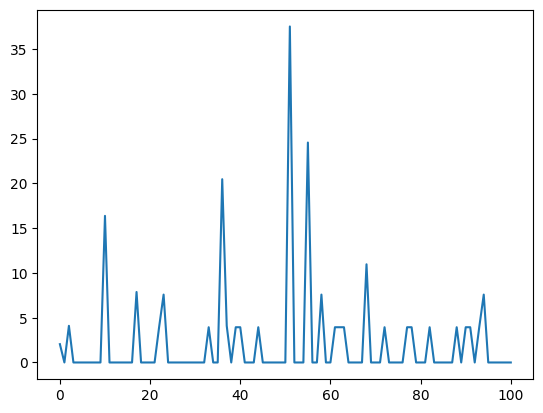

In [20]:
mean_costs = []
for cost in history['cost']:
    mean_costs.append(np.mean(cost))

plt.plot(np.arange(len(mean_costs)), mean_costs)
print(history.keys())
print(history['best'])
print(history['cost'][75][0])
print(history['point_sets'][75][0])
print(history['weight_sets'][75][0])